In [17]:
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import models, optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing import image
import shutil
import numpy as np
from PIL import Image
import os
import re
import pickle

current_dir = '../data/'
uecfood_dir = current_dir + 'UECFOOD100/'
dataset_dir = current_dir + 'dataset/'

In [8]:
os.getcwd()

'/Users/master/Desktop/ハッカソン/開発/2022_supporters_hackathon/src'

In [28]:
def list_pictures(directory, ext='jpg|jpeg|bmp|png|ppm'):
    return [os.path.join(root, f)
            for root, _, files in os.walk(directory) for f in files
            if re.match(r'([\w]+.(?:' + ext + '))', f.lower())]

In [111]:
for ctg_index in range(1,101):
    os.mkdir(dataset_dir + str(ctg_index))

In [112]:
for ctg_index in range(1,101):
    bb_info = []
    for line in open(uecfood_dir + str(ctg_index) + '/bb_info.txt', 'r'):
        bb_info.append(line[:-1].split())
    # 1行目はラベル行なので削除
    bb_info.pop(0)

    for line in bb_info:
        filename = line[0] + '.jpg'
        pic_img = Image.open(uecfood_dir + str(ctg_index) + '/' + filename)
        x1 = int(line[1])
        y1 = int(line[2])
        x2 = int(line[3])
        y2 = int(line[4])
        area = (x1, y1, x2, y2)
        pic_crop = pic_img.crop(area)
        # 新しく別のファイルとして保存
        pic_crop.save(dataset_dir + str(ctg_index) + '/' + filename, quality=100)

In [87]:
os.mkdir(dataset_dir + 'train')
os.mkdir(dataset_dir + 'test')

In [88]:
for ctg_index in range(1,101):
    os.mkdir(dataset_dir + 'train/' + str(ctg_index))
    os.mkdir(dataset_dir + 'test/' + str(ctg_index))

In [115]:
train_dir = dataset_dir + 'train/'
test_dir = dataset_dir + 'test/'

for ctg_index in range(1,101):
    count = 0
    for pic in list_pictures(dataset_dir + str(ctg_index)):
        count += 1
        if np.random.rand(1) < 0.2:
            shutil.move(pic, test_dir + str(ctg_index) + '/' + str(ctg_index) + '_' + str(count) + '.jpg')
        else:
            shutil.move(pic, train_dir + str(ctg_index) + '/' + str(ctg_index) + '_' + str(count)  + '.jpg')

In [116]:
for ctg_index in range(1,101):
    os.rmdir(dataset_dir + str(ctg_index))

In [117]:
# image_size = 224

# vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
# for layer in vgg_conv.layers[:-4]:
#     layer.trainable = False

# model = models.Sequential()
# model.add(vgg_conv)

# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(100, activation='softmax'))

# model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               102500    
Total params: 40,508,324
Trainable params: 32,873,060
Non-trainable params: 7,635,264
_________________________________________________________________


In [134]:
mobile_conv = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
mobile_conv.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [147]:
image_size = 224

mobile_conv = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
layer_names = [l.name for l in mobile_conv.layers]
idx = layer_names.index('block_15_expand')
print(idx)
for layer in mobile_conv.layers[:idx]:
    layer.trainable = False

model = models.Sequential()
model.add(mobile_conv)
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='softmax'))

model.summary()

134
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              1311744   
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               102500    
Total params: 3,672,228
Trainable params: 2,620,324
Non-trainable params: 1,051,904
_________________________________________________________________


In [119]:
# import cv2 # pip install opencv-python
# import matplotlib.pyplot as plt
# %matplotlib inline

# img = cv2.imread('data/dataset/train/1')
# # print(img)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.show()

In [148]:
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip = True
)

validation_datagen=ImageDataGenerator(rescale=1.0/255)

train_generator=train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator=validation_datagen.flow_from_directory(
    test_dir,
    target_size=(image_size,image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

Found 11528 images belonging to 100 classes.
Found 3033 images belonging to 100 classes.


/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [149]:
csv_logger = CSVLogger('../model/log/food_recongition_2.log')
hist=model.fit_generator(
    train_generator,
    epochs=80,
    verbose=1,
    validation_data=validation_generator,
    callbacks=[csv_logger]
)

#save weights
model.save('../model/food_recognition_ep80_2.h5')

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80


2022-06-18 19:45:36.360766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - ETA: 0s - loss: 4.6634 - accuracy: 0.0487

2022-06-18 19:47:13.875086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


361/361 [==============================] - 113s 308ms/step - loss: 4.6634 - accuracy: 0.0487 - val_loss: 4.2879 - val_accuracy: 0.0814
Epoch 2/80
361/361 [==============================] - 126s 349ms/step - loss: 4.1667 - accuracy: 0.1117 - val_loss: 3.9290 - val_accuracy: 0.1266
Epoch 3/80
361/361 [==============================] - 183s 506ms/step - loss: 3.8433 - accuracy: 0.1652 - val_loss: 3.5761 - val_accuracy: 0.2120
Epoch 4/80
361/361 [==============================] - 209s 578ms/step - loss: 3.5579 - accuracy: 0.2255 - val_loss: 3.2454 - val_accuracy: 0.2809
Epoch 5/80
361/361 [==============================] - 360s 999ms/step - loss: 3.2855 - accuracy: 0.2817 - val_loss: 2.9556 - val_accuracy: 0.3386
Epoch 6/80
361/361 [==============================] - 530s 1s/step - loss: 3.0078 - accuracy: 0.3315 - val_loss: 2.7013 - val_accuracy: 0.3937
Epoch 7/80
361/361 [==============================] - 385s 1s/step - loss: 2.7733 - accuracy: 0.3675 - val_loss: 2.4783 - val_accuracy: 0.

/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [150]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import japanize_matplotlib # pip install japanize_matplotlib
import matplotlib.style
matplotlib.style.use('ggplot')

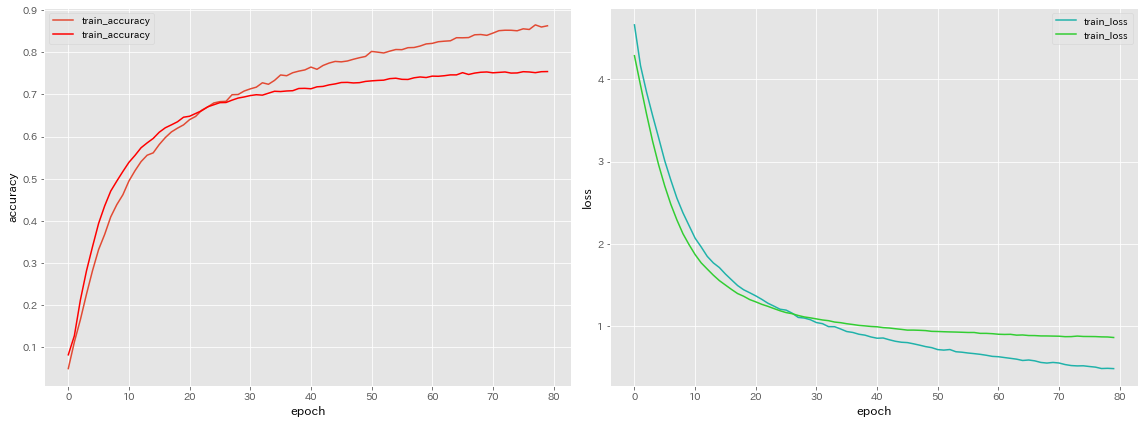

In [160]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(log['epoch'], log['accuracy'], label='train_accuracy')
ax1.plot(log['epoch'], log['val_accuracy'], label='train_accuracy', color='red')
ax2.plot(log['epoch'], log['loss'], label='train_loss', color='lightseagreen')
ax2.plot(log['epoch'], log['val_loss'], label='train_loss', color='limegreen')
ax1.set_xlabel('epoch', color='black')
ax2.set_xlabel('epoch', color='black')
ax1.set_ylabel('accuracy', color='black')
ax2.set_ylabel('loss', color='black')
ax1.legend(loc='best')
ax2.legend(loc='best')
plt.tight_layout()
plt.show()

In [224]:
import pandas as pd
from tensorflow.keras.preprocessing import image

def get_ctgname_by_index(index):
    # ary_ctgname = []
    # for line in open('data/UECFOOD100/category_ja_utf8.txt', 'r'):
    #     ary_ctgname.append(line[:-1].split())
    df_category = pd.read_pickle(dataset_dir + '/category/category_df.pkl')

    ctg_dic = train_generator.class_indices # ('1': 0) = (元データのラベル付 : 訓練時のラベル付)
    key = [k for k, v in ctg_dic.items() if v == index] # 訓練時のラベルと予測ラベルが同じ時、元データのラベルを返す
    id = int(key[0])
    ctg_name_index = 1
    # ctg_name = ary_ctgname[int(id)][ctg_name_index] # 元データのラベルから、カテゴリ名を取得
    ctg_name = df_category.iloc[int(id)-1, ctg_name_index]
    return ctg_name

In [250]:
ctg_dic = train_generator.class_indices

In [251]:
type(ctg_dic)

dict

In [255]:
import pickle
with open(dataset_dir + "category/train_generator_class_indices_2.pkl", "wb") as tf:
    pickle.dump(ctg_dic,tf)

In [12]:
with open(dataset_dir + 'category/train_generator_class_indices.pkl', 'rb') as tf:
    ctg = pickle.load(tf)
ctg

{'1': 0,
 '10': 1,
 '100': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '23': 16,
 '24': 17,
 '25': 18,
 '26': 19,
 '27': 20,
 '28': 21,
 '29': 22,
 '3': 23,
 '30': 24,
 '31': 25,
 '32': 26,
 '33': 27,
 '34': 28,
 '35': 29,
 '36': 30,
 '37': 31,
 '38': 32,
 '39': 33,
 '4': 34,
 '40': 35,
 '41': 36,
 '42': 37,
 '43': 38,
 '44': 39,
 '45': 40,
 '46': 41,
 '47': 42,
 '48': 43,
 '49': 44,
 '5': 45,
 '50': 46,
 '51': 47,
 '52': 48,
 '53': 49,
 '54': 50,
 '55': 51,
 '56': 52,
 '57': 53,
 '58': 54,
 '59': 55,
 '6': 56,
 '60': 57,
 '61': 58,
 '62': 59,
 '63': 60,
 '64': 61,
 '65': 62,
 '66': 63,
 '67': 64,
 '68': 65,
 '69': 66,
 '7': 67,
 '70': 68,
 '71': 69,
 '72': 70,
 '73': 71,
 '74': 72,
 '75': 73,
 '76': 74,
 '77': 75,
 '78': 76,
 '79': 77,
 '8': 78,
 '80': 79,
 '81': 80,
 '82': 81,
 '83': 82,
 '84': 83,
 '85': 84,
 '86': 85,
 '87': 86,
 '88': 87,
 '89': 88,
 '9': 89,
 '90': 90,
 '91': 91,
 '92':

In [13]:
import pandas as pd
df_category = pd.read_pickle(dataset_dir + '/category/category_df.pkl')
df_category.head(20)

,id,name
0,1,ごはん
1,2,うな重
2,3,ピラフ
3,4,親子丼
4,5,カツ丼
5,6,カレーライス
6,7,寿司
7,8,チキンライス
8,9,チャーハン
9,10,天丼


In [163]:
os.mkdir(dataset_dir + 'validation')

In [244]:
img = image.load_img(dataset_dir + 'validation/ramen.jpeg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

(1, 224, 224, 3)

In [245]:
#img_data = request.files['input_file'].stream
#img = Image.open(img_data).convert(mode='RGB')
img = Image.open(dataset_dir + 'validation/ramen.jpeg').convert(mode='RGB')
image_size = 224
img = img.resize((image_size, image_size))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

(1, 224, 224, 3)

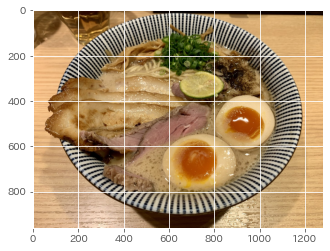

In [176]:
# import cv2 # pip install opencv-python
# import matplotlib.pyplot as plt
# %matplotlib inline

# img = cv2.imread('data/dataset/validation/ramen.jpeg')
# # print(img)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# plt.show()

In [20]:
img = image.load_img(dataset_dir + 'validation/ramen.jpeg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0
x

array([[[[0.57254905, 0.41960785, 0.2509804 ],
         [0.5647059 , 0.41960785, 0.24705882],
         [0.5568628 , 0.4117647 , 0.23921569],
         ...,
         [0.04705882, 0.02745098, 0.01176471],
         [0.04705882, 0.02745098, 0.01176471],
         [0.03529412, 0.01568628, 0.        ]],

        [[0.58431375, 0.43137255, 0.2627451 ],
         [0.5647059 , 0.41960785, 0.24705882],
         [0.5294118 , 0.39607844, 0.21960784],
         ...,
         [0.08235294, 0.02352941, 0.00392157],
         [0.07843138, 0.01960784, 0.        ],
         [0.07843138, 0.01960784, 0.        ]],

        [[0.5568628 , 0.4117647 , 0.23921569],
         [0.5019608 , 0.36862746, 0.19215687],
         [0.49803922, 0.3647059 , 0.1882353 ],
         ...,
         [0.08627451, 0.03529412, 0.00392157],
         [0.07058824, 0.01960784, 0.        ],
         [0.07843138, 0.02745098, 0.        ]],

        ...,

        [[0.8627451 , 0.6862745 , 0.52156866],
         [0.8666667 , 0.6901961 , 0.5254902 ]

In [19]:
pred = model.predict(x)[0]
pred

NameError: name 'model' is not defined

In [195]:
K = 5
unsorted_max_indices = np.argpartition(-pred, K)[:K]
y = pred[unsorted_max_indices]
print(unsorted_max_indices)
print(y)

[17 16 43 54 48]
[0.6486766  0.30031434 0.01484167 0.00434162 0.00409246]


In [196]:
indices = np.argsort(-y)
top5_indices = unsorted_max_indices[indices]
print(top5_indices)

[17 16 43 54 48]


In [226]:
for index in top5_indices:
    ctg_name = get_ctgname_by_index(index)
    print(ctg_name + ":" + str(pred[index]))

チャーシューメン:0.6486766
ラーメン:0.30031434
刺身:0.014841666
煮魚:0.0043416154
たたき:0.004092459


In [25]:
import pickle

def pickle_load(path: str): # return Any
    """pickleファイルを変数objとして読み込み"""
    with open(path, mode="rb") as f:
        data = pickle.load(f)
        return data

def get_ctgname_by_index(index: int) -> str:
    """予測したindexからそのカテゴリ名を返す関数"""
    df_category: pd.DataFrame = pd.read_pickle("../data/dataset/category/category_df.pkl") # 元のデータラベルデータフレームを取得
    ctg_dic: dict = pickle_load("../data/dataset/category/train_generator_class_indices.pkl")
    key: list[int] = [k for k, v in ctg_dic.items() if v == index] # 訓練時のラベルと予測ラベルが同じ時、元データのラベルを返す
    id: int = int(key[0]) # 元のデータセットのラベル
    ctg_name_index: int = 1 # カテゴリ名の列を取得するためのカラムインデックス
    ctg_name: str = df_category.iloc[int(id)-1, ctg_name_index] # 引数indexに対するカテゴリ名
    return ctg_name

In [26]:
img_data = x
model_name: str = "../model/food_recognition_ep80.h5"
K = 5
model = load_model(model_name) # モデルのロード
pred: np.ndarray = model.predict(img_data)[0] # カテゴリの予測
# 予測カテゴリのうち上位K個を取得
unsorted_max_indices: np.ndarray = np.argpartition(-pred, K)[:K]
y: np.ndarray = pred[unsorted_max_indices]
indices: np.ndarray = np.argsort(-y)
topK_indices: np.ndarray = unsorted_max_indices[indices]
# 予測カテゴリのidからカテゴリ名を取得
result: list = []
for index in topK_indices:
    ctg_name: str = get_ctgname_by_index(index)
    result.append([ctg_name, str(pred[index])])
    # print(ctg_name + ":" + str(pred[index]))
result

2022-06-19 14:02:09.580936: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[['チャーシューメン', '0.6486766'],
 ['ラーメン', '0.30031434'],
 ['刺身', '0.014841666'],
 ['煮魚', '0.0043416154'],
 ['たたき', '0.004092459']]

In [30]:
[r[0] for r in result]

['チャーシューメン', 'ラーメン', '刺身', '煮魚', 'たたき']

In [31]:
result_2 = ' '.join([r[0] for r in result])
result_2

'チャーシューメン ラーメン 刺身 煮魚 たたき'